In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [14]:
import os
from pydub import AudioSegment
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder

In [15]:
def convert_mp3_to_wav(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".mp3"):
                mp3_path = os.path.join(root, file)
                wav_subfolder = os.path.join(output_folder, os.path.relpath(root, input_folder))
                if not os.path.exists(wav_subfolder):
                    os.makedirs(wav_subfolder)
                wav_path = os.path.join(wav_subfolder, os.path.splitext(file)[0] + ".wav")
                audio = AudioSegment.from_mp3(mp3_path)
                audio.export(wav_path, format="wav")
                print(f"Converted: {mp3_path} -> {wav_path}")


In [16]:
train_dir = "/content/drive/My Drive/stutter_datasets/train/"
train_wav_dir = "/content/drive/My Drive/stutter_datasets_wav/train/"
convert_mp3_to_wav(train_dir, train_wav_dir)

test_dir = "/content/drive/My Drive/stutter_datasets/test/"
test_wav_dir = "/content/drive/My Drive/stutter_datasets_wav/test/"
convert_mp3_to_wav(test_dir, test_wav_dir)

print("Train WAV files:", os.listdir(train_wav_dir))
print("Test WAV files:", os.listdir(test_wav_dir))

Converted: /content/drive/My Drive/stutter_datasets/train/Prolongations/ElevenLabs_2024-12-04T14_53_40_Roger_pre_s50_sb75_se0_b.mp3 -> /content/drive/My Drive/stutter_datasets_wav/train/Prolongations/ElevenLabs_2024-12-04T14_53_40_Roger_pre_s50_sb75_se0_b.wav
Converted: /content/drive/My Drive/stutter_datasets/train/Prolongations/ElevenLabs_2024-12-04T14_54_19_Alice_pre_s50_sb75_se0_b.mp3 -> /content/drive/My Drive/stutter_datasets_wav/train/Prolongations/ElevenLabs_2024-12-04T14_54_19_Alice_pre_s50_sb75_se0_b.wav
Converted: /content/drive/My Drive/stutter_datasets/train/Prolongations/ElevenLabs_2024-12-04T14_55_12_Bill_pre_s50_sb75_se0_b.mp3 -> /content/drive/My Drive/stutter_datasets_wav/train/Prolongations/ElevenLabs_2024-12-04T14_55_12_Bill_pre_s50_sb75_se0_b.wav
Converted: /content/drive/My Drive/stutter_datasets/train/Prolongations/ElevenLabs_2024-12-04T14_55_55_Callum_pre_s50_sb75_se0_b.mp3 -> /content/drive/My Drive/stutter_datasets_wav/train/Prolongations/ElevenLabs_2024-12-04

In [64]:
import librosa
import numpy as np
import random

def extract_features(file_path, max_len=200, augment=False):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, sr=None)

        # Apply data augmentation if enabled
        if augment:
            audio = apply_augmentation(audio, sample_rate)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)

        # Pad or truncate to ensure consistent length
        if mfccs.shape[1] < max_len:
            mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def apply_augmentation(audio, sample_rate):
    """Apply random augmentations to the audio."""
    augmentation_functions = [
        lambda x: add_noise(x),
        lambda x: change_speed(x, factor=random.uniform(0.9, 1.1)),
        lambda x: change_pitch(x, sample_rate, n_steps=random.randint(-2, 2))
    ]
    augmentation = random.choice(augmentation_functions)
    return augmentation(audio)


def add_noise(audio, noise_level=0.005):
    """Add random noise to the audio."""
    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise

def change_speed(audio, factor=1.0):
    """
    Change the speed of the audio.
    :param audio: Input audio signal (1D NumPy array)
    :param factor: Speed factor (e.g., 1.1 for faster, 0.9 for slower)
    :return: Modified audio signal
    """
    return librosa.effects.time_stretch(audio, rate=factor)


def change_pitch(audio, sample_rate, n_steps=0):
    """Change the pitch of the audio."""
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=n_steps)


In [70]:
def load_data(data_dir, augment=False):
    features = []
    labels = []
    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                if file_path.endswith(".wav"):
                    mfccs = extract_features(file_path, augment=augment)  # Pass augment flag
                    if mfccs is not None:
                        features.append(mfccs)
                        labels.append([class_label])
    features = np.stack(features, axis=0)
    return np.array(features), np.array(labels)


In [71]:
train_dir = "/content/drive/My Drive/stutter_datasets_wav/train/"
test_dir = "/content/drive/My Drive/stutter_datasets_wav/test/"

X_train, y_train = load_data(train_dir, augment=True)
X_test, y_test = load_data(test_dir, augment=False)

In [72]:
from sklearn.preprocessing import MultiLabelBinarizer

class_labels = ['Single Syllable Repetitions', 'Whole Word Repetitions', 'Prolongations']
mlb = MultiLabelBinarizer(classes=class_labels)

y_train_multi = mlb.fit_transform(y_train)
y_test_multi = mlb.transform(y_test)

print("Binary Labels Example (y_train_multi):", y_train_multi[:5])

Binary Labels Example (y_train_multi): [[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [73]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation subsets
X_train_split, X_val, y_train_split, y_val_multi = train_test_split(
    X_train, y_train_multi, test_size=0.2, random_state=42
)

# Check shapes of the splits
print(f"Training set shape: {X_train_split.shape}, {y_train_split.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val_multi.shape}")


Training set shape: (48, 13, 200), (48, 3)
Validation set shape: (12, 13, 200), (12, 3)


In [89]:
# Check the number of training and test samples
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

# Verify labels match the features
print(f"Number of training labels: {y_train_multi.shape[0]}")
print(f"Number of test labels: {y_test_multi.shape[0]}")


Number of training samples: 60
Number of test samples: 15
Number of training labels: 60
Number of test labels: 15


In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Bidirectional, Dense, Dropout, TimeDistributed, Reshape
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Reshape((-1, 64)),

    Bidirectional(LSTM(32)),
    Dropout(0.3),

    Dense(len(class_labels), activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam

# Define a smaller learning rate
optimizer = Adam(learning_rate=0.001)

# Callback to reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 11, 198, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 11, 198, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 99, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 5, 99, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 97, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 3, 97, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 48, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 48, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,227 (172.76 KB)

 Trainable params: 44,035 (172.01 KB)

 Non-trainable params: 192 (768.00 B)

In [84]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [85]:
# Train model
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val_multi),
    epochs=30,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],  # Added callbacks
    verbose=1
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.3203 - loss: 0.6990 - val_accuracy: 0.3333 - val_loss: 0.7017 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.3125 - loss: 0.6294 - val_accuracy: 0.2500 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4583 - loss: 0.5954 - val_accuracy: 0.0833 - val_loss: 0.7160 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5964 - loss: 0.5580 - val_accuracy: 0.3333 - val_loss: 0.6853 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6641 - loss: 0.5406 - val_accuracy: 0.3333 - val_loss: 0.6755 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6693 - loss: 0.5202 - val_accuracy: 0.3333 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5807 - loss: 0.5345 - val_accuracy: 0.33

In [86]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_multi, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3333 - loss: 0.6357
Test Loss: 0.6357, Test Accuracy: 0.3333


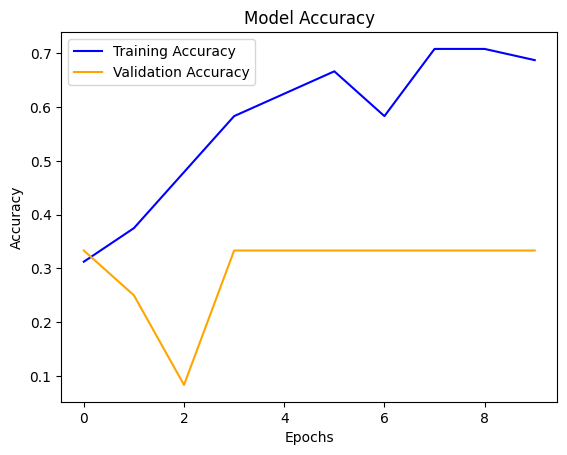

In [87]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

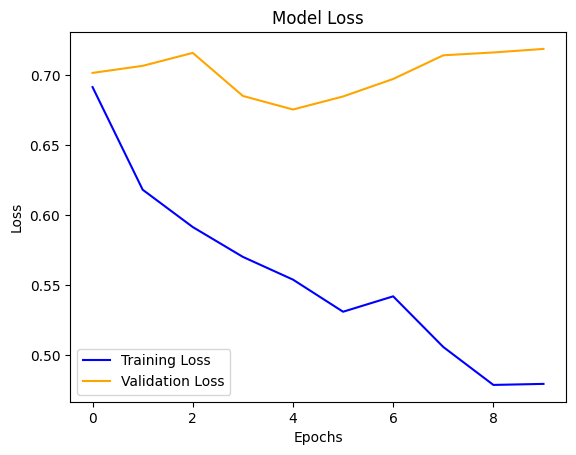

In [88]:
# Loss plot
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

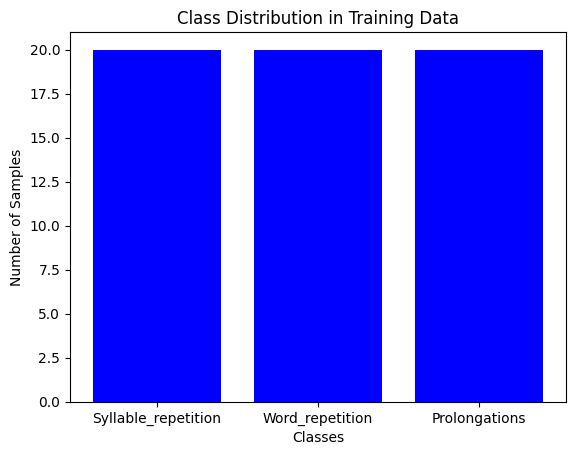

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Summing binary labels along the samples axis to get the count for each class
class_counts = np.sum(y_train_multi, axis=0)
class_labels = ['Syllable_repetition', 'Word_repetition', 'Prolongations']

# Bar plot for class distribution
plt.bar(class_labels, class_counts, color='blue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()


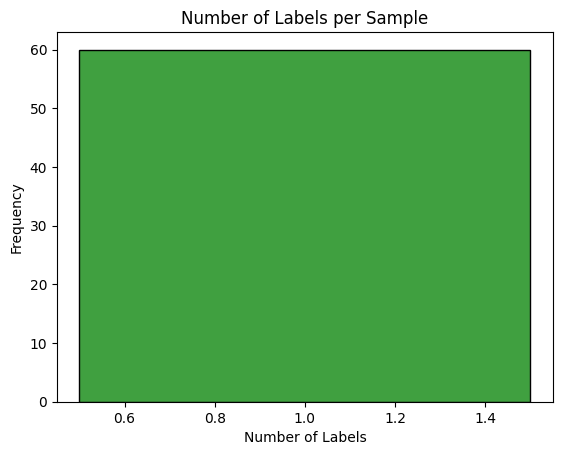

In [81]:
import seaborn as sns

# Count samples with multiple labels
num_labels_per_sample = np.sum(y_train_multi, axis=1)

# Histogram of number of labels per sample
sns.histplot(num_labels_per_sample, discrete=True, kde=False, color='green')
plt.title('Number of Labels per Sample')
plt.xlabel('Number of Labels')
plt.ylabel('Frequency')
plt.show()


In [82]:
# Predict on a few test samples
predictions = model.predict(X_test[:5])
predicted_classes = (predictions > 0.5).astype(int)  # Apply threshold

# Ensure y_test_multi is a NumPy array
y_test_multi = np.array(y_test_multi)

# Loop through predictions and true labels
for i in range(len(predictions)):
    print(f"Sample {i+1}")

    # Ensure both true and predicted labels are in the correct shape
    true_labels = mlb.inverse_transform(np.array([y_test_multi[i]]))[0]  # True labels
    predicted_labels = mlb.inverse_transform(np.array([predicted_classes[i]]))[0]  # Predicted labels

    # Print results
    print("True Labels:", true_labels)
    print("Predicted Labels:", predicted_labels)
    print()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Sample 1
True Labels: ('Prolongations',)
Predicted Labels: ('Single Syllable Repetitions',)

Sample 2
True Labels: ('Prolongations',)
Predicted Labels: ()

Sample 3
True Labels: ('Prolongations',)
Predicted Labels: ()

Sample 4
True Labels: ('Prolongations',)
Predicted Labels: ()

Sample 5
True Labels: ('Prolongations',)
Predicted Labels: ()



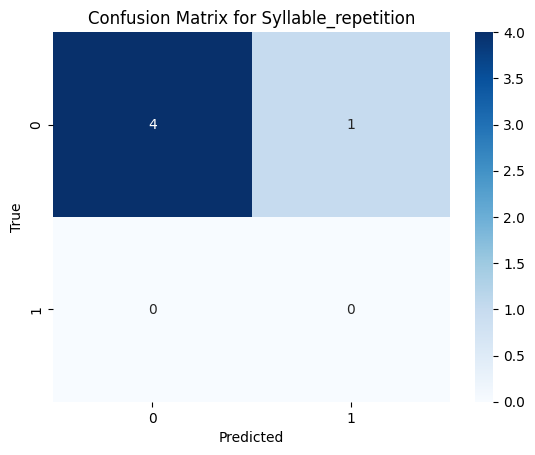

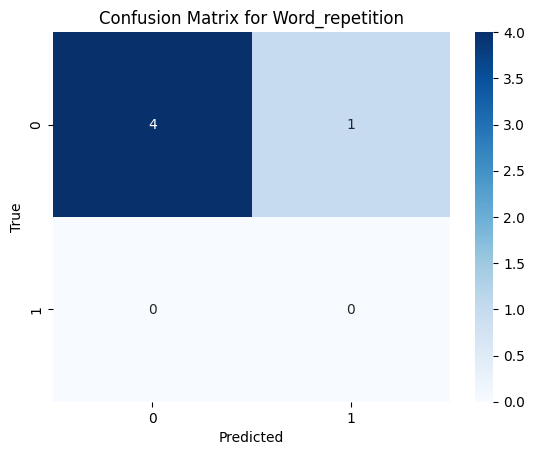

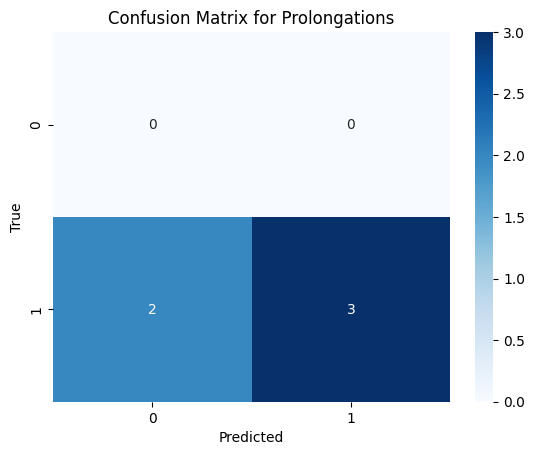

Classification Report:
                      precision    recall  f1-score   support

Syllable_repetition       0.00      0.00      0.00         0
    Word_repetition       0.00      0.00      0.00         0
      Prolongations       1.00      0.60      0.75         5

          micro avg       0.60      0.60      0.60         5
          macro avg       0.33      0.20      0.25         5
       weighted avg       1.00      0.60      0.75         5
        samples avg       0.60      0.60      0.60         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Ensure consistent sample sizes
true_labels_subset = y_test_multi[:5]  # Use the first 5 labels to match predictions

# Generate confusion matrices for each class
confusion_matrices = multilabel_confusion_matrix(true_labels_subset, (predictions > 0.5).astype(int))

# Plot confusion matrix for each class
for i, label in enumerate(class_labels):
    cm = confusion_matrices[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Classification report
print("Classification Report:\n", classification_report(true_labels_subset, (predictions > 0.5).astype(int), target_names=class_labels))



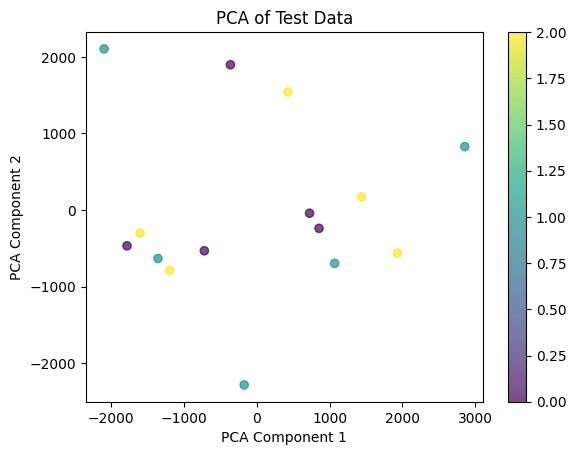

Number of samples in X_test_flat: 15


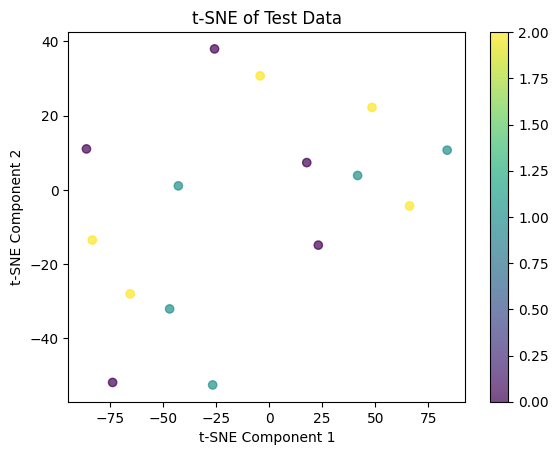

Shape of X_test_flat: (15, 2600)


In [47]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Flatten features to 2D for visualization
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_flat)

# Plot PCA results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.argmax(y_test_multi, axis=1), cmap='viridis', alpha=0.7)
plt.title('PCA of Test Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

# Check the number of samples in the test set
n_samples = X_test_flat.shape[0]
print(f"Number of samples in X_test_flat: {n_samples}")

# Set perplexity to a value less than the number of samples
tsne = TSNE(n_components=2, perplexity=min(5, n_samples - 1), random_state=42)  # Ensure perplexity < n_samples
X_tsne = tsne.fit_transform(X_test_flat)

# Plot t-SNE results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(y_test_multi, axis=1), cmap='viridis', alpha=0.7)
plt.title('t-SNE of Test Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()
print(f"Shape of X_test_flat: {X_test_flat.shape}")
